In [19]:
import pandas as pd

# Load datasets
cus_data = pd.read_csv("sample_data/customer_data.csv")
cus_tickets = pd.read_csv("sample_data/customer_support_tickets.csv")
reviews = pd.read_csv("sample_data/amazon_review.csv")

In [20]:
import hashlib

# Function to create a unique user ID
def make_user_id(base: str) -> str:
    return hashlib.md5(base.encode()).hexdigest()[:12]

In [24]:
# Add user_id to customer data
cus_data['user_id'] = cus_data['id'].astype(str).apply(make_user_id)

In [31]:
customer_df = pd.DataFrame(
    {
        "user_id": cus_data["user_id"],
        "age": cus_data["age"],
        "gender": cus_data["gender"],
        "location": cus_data["region"],
        "income": cus_data["income"],
        "education": cus_data["education"],
        "loyalty_status": cus_data["loyalty_status"],
        "account_age_days": None,
        "premium": cus_data["loyalty_status"].apply(lambda x: x == "Gold" or x == "Silver"),
        "device": None
    }
)

In [32]:
customer_df.head()

,user_id,age,gender,location,income,education,loyalty_status,account_age_days,premium,device
0,c4ca4238a0b9,27,Male,East,40682,Bachelor,Gold,None,True,None
1,c81e728d9d4c,29,Male,West,15317,Masters,Regular,None,False,None
2,eccbc87e4b5c,37,Male,West,38849,Bachelor,Silver,None,True,None
3,a87ff679a2f3,30,Male,South,11568,HighSchool,Regular,None,False,None
4,e4da3b7fbbce,31,Female,North,46952,College,Regular,None,False,None


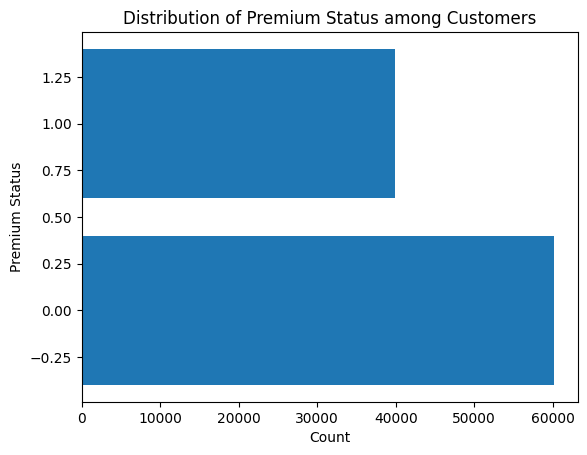

In [33]:
import matplotlib.pyplot as plt

plt.barh(customer_df['premium'].value_counts().index, customer_df['premium'].value_counts().values)
plt.xlabel('Count')
plt.ylabel('Premium Status')
plt.title('Distribution of Premium Status among Customers')
plt.show()

In [ ]:
import numpy as np
import pandas as pd

# ---------------------------
# ACCOUNT AGE DAYS AUGMENTATION
# ---------------------------

def generate_account_age(n):
    samples = []
    for _ in range(n):
        r = np.random.rand()
        if r < 0.20:
            samples.append(np.random.randint(0, 31))              # 0–30 days
        elif r < 0.45:
            samples.append(np.random.randint(31, 91))             # 31–90 days
        elif r < 0.75:
            samples.append(np.random.randint(91, 366))            # 91–365 days
        elif r < 0.95:
            samples.append(np.random.randint(366, 1001))          # 1–3 years
        else:
            samples.append(np.random.randint(1001, 1801))         # 3–5 years
    return samples

customer_df["account_age_days"] = generate_account_age(len(customer_df))

# ---------------------------
# DEVICE TYPE AUGMENTATION
# ---------------------------

def choose_device(age, income):
    # Younger users → mobile biased
    if age < 25:
        return np.random.choice(["Android", "iOS", "Web"], p=[0.7, 0.2, 0.1])
    
    # High income → more iOS
    if income > 40000:
        return np.random.choice(["iOS", "Android", "Web"], p=[0.5, 0.4, 0.1])
    
    # Older → more Web usage
    if age > 40:
        return np.random.choice(["Web", "Android", "iOS"], p=[0.4, 0.4, 0.2])
    
    # Default distribution
    return np.random.choice(["Android", "iOS", "Web"], p=[0.55, 0.30, 0.15])

customer_df["device"] = customer_df.apply(lambda row: choose_device(row["age"], row["income"]), axis=1)

        user_id  age  gender location  income   education loyalty_status  \
0  c4ca4238a0b9   27    Male     East   40682    Bachelor           Gold   
1  c81e728d9d4c   29    Male     West   15317     Masters        Regular   
2  eccbc87e4b5c   37    Male     West   38849    Bachelor         Silver   
3  a87ff679a2f3   30    Male    South   11568  HighSchool        Regular   
4  e4da3b7fbbce   31  Female    North   46952     College        Regular   

   account_age_days  premium device  
0                31     True    Web  
1               861    False    iOS  
2                16     True    iOS  
3                 1    False    iOS  
4                11    False    Web  


In [35]:
customer_df.head()

,user_id,age,gender,location,income,education,loyalty_status,account_age_days,premium,device
0,c4ca4238a0b9,27,Male,East,40682,Bachelor,Gold,31,True,Web
1,c81e728d9d4c,29,Male,West,15317,Masters,Regular,861,False,iOS
2,eccbc87e4b5c,37,Male,West,38849,Bachelor,Silver,16,True,iOS
3,a87ff679a2f3,30,Male,South,11568,HighSchool,Regular,1,False,iOS
4,e4da3b7fbbce,31,Female,North,46952,College,Regular,11,False,Web


In [36]:
import pandas as pd
import numpy as np
import uuid
from datetime import datetime, timedelta
import random
import json

# Event types & their metadata templates
EVENT_TYPES = {
    "app_open": {},
    "page_view": {"page": ["home", "search", "product", "profile"]},
    "search": {"query": ["shoes", "laptop", "t-shirt", "iphone", "watch"]},
    "view_product": {"product_id": list(range(1000, 1100))},
    "add_to_cart": {"product_id": list(range(1000, 1100))},
    "remove_from_cart": {"product_id": list(range(1000, 1100))},
    "apply_coupon": {"coupon": ["NEW10", "SALE20", "FREESHIP"]},
    "purchase": {"payment_method": ["upi", "card", "cod"]},
    "payment_failed": {"reason": ["insufficient_funds", "card_declined", "timeout"]},
    "order_cancelled": {"reason": ["customer_request", "payment_issue", "inventory"]},
    "wishlist_add": {"product_id": list(range(1000, 1100))},
    
    # Engagement / NLP-related
    "rating_given": {"rating": [1,2,3,4,5]},
    "review_submitted": {"tags": ["delivery", "quality", "packaging", "service"]},
    "ticket_created": {"priority": ["low", "medium", "high"]},
    "ticket_closed": {"resolution": ["refund", "replacement", "info_provided"]},

    # Marketing
    "email_open": {"campaign": ["promo_jan", "promo_feb", "winback"]},
    "push_notification_open": {"title": ["flash_sale", "price_drop", "new_arrival"]},
}

def generate_metadata(template):
    """Generate metadata JSON based on event type template."""
    meta = {}
    for k, v in template.items():
        meta[k] = random.choice(v)
    return json.dumps(meta)

def generate_events_for_user(user_id, start_date, num_events=200):
    """Generate sequential events for a user with timestamps."""
    events = []
    current_time = start_date

    for _ in range(num_events):
        event_type = random.choice(list(EVENT_TYPES.keys()))
        metadata = generate_metadata(EVENT_TYPES[event_type])
        
        events.append({
            "event_id": str(uuid.uuid4()),
            "user_id": user_id,
            "timestamp": current_time.isoformat(),
            "event_type": event_type,
            "metadata": metadata
        })

        # Next event occurs after 5–60 minutes
        current_time += timedelta(minutes=np.random.randint(5, 60))

    return events


# Generate events for all users
all_events = []

for _, row in customer_df.iterrows():
    user_id = row["user_id"]
    account_age_days = row["account_age_days"]

    start_date = datetime.now() - timedelta(days=account_age_days)
    num_events = np.random.randint(100, 400)  # activity varies

    events = generate_events_for_user(user_id, start_date, num_events)
    all_events.extend(events)

events_df = pd.DataFrame(all_events)

events_df.head()

,event_id,user_id,timestamp,event_type,metadata
0,45e109aa-07c2-4570-bebd-f36df55fa618,c4ca4238a0b9,2025-11-02T09:47:24.134980,purchase,"{""payment_method"": ""cod""}"
1,68fb776f-e29f-47c3-96dc-cfc82f04b42b,c4ca4238a0b9,2025-11-02T10:19:24.134980,payment_failed,"{""reason"": ""timeout""}"
2,221da107-806c-4202-bdb6-ee4a6895b915,c4ca4238a0b9,2025-11-02T11:05:24.134980,review_submitted,"{""tags"": ""quality""}"
3,3e66a786-c6c4-40e0-8f61-ad901e541d0e,c4ca4238a0b9,2025-11-02T11:44:24.134980,remove_from_cart,"{""product_id"": 1063}"
4,5082a4ab-8888-4c47-af3e-8517d9d6819d,c4ca4238a0b9,2025-11-02T11:57:24.134980,push_notification_open,"{""title"": ""new_arrival""}"


In [37]:
events_df.shape

(24957690, 5)

In [41]:
events_df.to_csv("synthetic_data/event_logs.csv", index=False)
customer_df.to_csv("synthetic_data/customer_data.csv", index=False)

In [43]:
customer_ids = list(customer_df["user_id"].unique())

print(f"Loaded {len(customer_ids)} synthetic customer IDs.")


print("Reviews loaded:", len(reviews))

# ---------------------------------------------------------------------
# 3. Create Deterministic Mapping from reviewerID → synthetic user_id
# ---------------------------------------------------------------------

def map_to_user_id(reviewer_id):
    """Deterministically pick a user_id using hash modulus."""
    idx = int(hashlib.md5(str(reviewer_id).encode()).hexdigest(), 16) % len(customer_ids)
    return customer_ids[idx]

reviews["user_id"] = reviews["reviewerID"].apply(map_to_user_id)

# ---------------------------------------------------------------------
# 4. Clean & Rename Columns
# ---------------------------------------------------------------------
review_df = reviews.rename(columns={
    "asin": "product_id",
    "reviewText": "review_text",
    "overall": "rating",
    "reviewTime": "review_date_str",
    "unixReviewTime": "unix_time",
    "summary": "summary",
    "helpful_yes": "helpful_yes",
    "total_vote": "total_votes"
})

# ---------------------------------------------------------------------
# 5. Process Review Time
# ---------------------------------------------------------------------
if "unix_time" in review_df.columns:
    review_df["review_time"] = pd.to_datetime(review_df["unix_time"], unit="s")
else:
    review_df["review_time"] = pd.to_datetime(review_df["review_date_str"], errors="coerce")

# ---------------------------------------------------------------------
# 6. Clean Text Fields
# ---------------------------------------------------------------------
review_df["review_text"] = review_df["review_text"].fillna("")
review_df["summary"] = review_df["summary"].fillna("")

# ---------------------------------------------------------------------
# 7. Ratings + Votes Fix
# ---------------------------------------------------------------------
review_df["rating"] = review_df["rating"].fillna(review_df["rating"].median())

review_df["helpful_yes"] = review_df.get("helpful_yes", pd.Series([0]*len(review_df)))
review_df["total_votes"] = review_df.get("total_votes", pd.Series([0]*len(review_df)))

review_df["helpful_ratio"] = review_df.apply(
    lambda row: row["helpful_yes"] / row["total_votes"] if row["total_votes"] > 0 else 0,
    axis=1
)

review_df["text_length"] = review_df["review_text"].apply(lambda x: len(str(x)))

# ---------------------------------------------------------------------
# 8. Placeholder NLP category (you will fill using topic modeling later)
# ---------------------------------------------------------------------
review_df["category"] = "general"

# ---------------------------------------------------------------------
# 9. Select Final Schema
# ---------------------------------------------------------------------
review_table = review_df[[
    "user_id",
    "product_id",
    "review_text",
    "summary",
    "rating",
    "review_time",
    "helpful_yes",
    "total_votes",
    "helpful_ratio",
    "text_length",
    "category"
]]

# ---------------------------------------------------------------------
# 10. Save Final Clean Table
# ---------------------------------------------------------------------
review_table.to_csv("clean_review_table.csv", index=False)

print("Review table created successfully!")
print(review_table.head())
print("Total rows:", len(review_table))

Loaded 100000 synthetic customer IDs.
Reviews loaded: 4915
Review table created successfully!
        user_id  product_id  \
0  0a9c1911c5cb  B007WTAJTO   
1  fa7482659fd7  B007WTAJTO   
2  35f44bc41975  B007WTAJTO   
3  d55818505899  B007WTAJTO   
4  92a05f3584af  B007WTAJTO   

                                         review_text  \
0                                         No issues.   
1  Purchased this for my device, it worked as adv...   
2  it works as expected. I should have sprung for...   
3  This think has worked out great.Had a diff. br...   
4  Bought it with Retail Packaging, arrived legit...   

                                  summary  rating review_time  helpful_yes  \
0                              Four Stars     4.0  2014-07-23            0   
1                           MOAR SPACE!!!     5.0  2013-10-25            0   
2               nothing to really say....     4.0  2012-12-23            0   
3  Great buy at this price!!!  *** UPDATE     5.0  2013-11-21         

In [42]:
reviews.shape

(4915, 12)

In [46]:
import pandas as pd
import numpy as np

# Load your cleaned user table (already created earlier)
user_df = cus_data
user_df['user_id'] = customer_df['user_id']

# Ensure column exists
if "satisfaction_score" not in user_df.columns:
    raise ValueError("satisfaction_score missing in user data")

# -------------------------------------------------------------------
# Churn Logic Function
# -------------------------------------------------------------------
def assign_churn(score):
    if score <= 3:
        return 1  # definitely churned
    elif 4 <= score <= 6:
        # probabilistic churn simulation
        prob_map = {4: 0.7, 5: 0.5, 6: 0.3}
        return np.random.rand() < prob_map[score]
    else:
        return 0  # happy customers don't churn

# Apply to dataset
user_df["churned"] = user_df["satisfaction_score"].apply(assign_churn).astype(int)

# Prepare target table
target_table = user_df[["user_id", "satisfaction_score", "churned"]]

# Save target table
target_table.to_csv("target_table.csv", index=False)

print("Target table created successfully!")
print(target_table.head())


Target table created successfully!
        user_id  satisfaction_score  churned
0  c4ca4238a0b9                   6        0
1  c81e728d9d4c                   6        0
2  eccbc87e4b5c                   6        0
3  a87ff679a2f3                   7        0
4  e4da3b7fbbce                   5        0


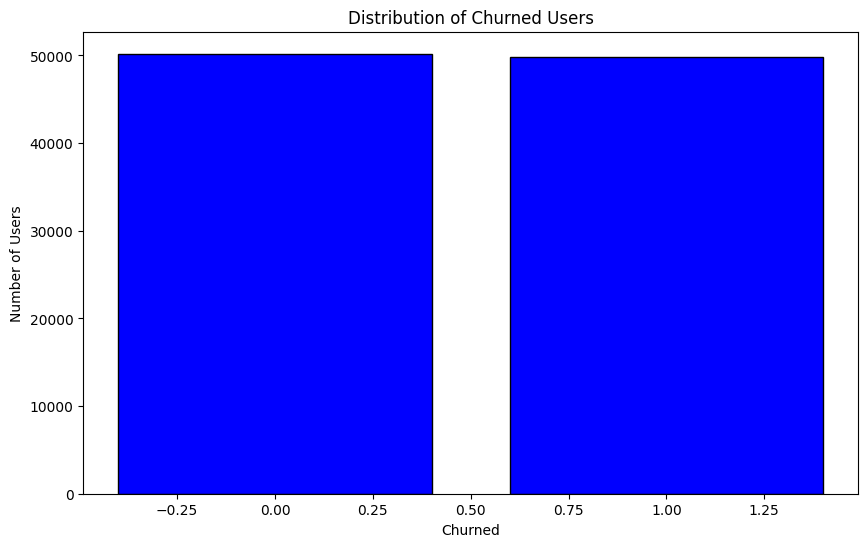

In [52]:
plt.figure(figsize=(10, 6))
plt.bar(user_df['churned'].value_counts().index,user_df['churned'].value_counts().values,color='blue', edgecolor='black')
plt.xlabel('Churned')
plt.ylabel('Number of Users')
plt.title('Distribution of Churned Users')
plt.show()